# Import

In [2]:
from sentence_transformers import SentenceTransformer, util
import torch
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel

import sqlite3
import argparse
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import os
from numpy.linalg import norm
import sys
from itertools import combinations
import random
import json
import my_utils

/home/grads/t/tiendat.ng.cs/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# exclude stacktrace

def remove_stacktrace(dataset):
    desc_wo_stacktrace = []
    for point in tqdm(dataset):
        desc = point["description"]
        stacktraces = point["stacktrace"]
        for stacktrace in stacktraces:
            desc = desc.replace(stacktrace["exception"], "")
            if stacktrace["message"] is not None: desc = desc.replace(stacktrace["message"], "")
            if stacktrace["frames"] is not None:
                for frame in stacktrace["frames"]:
                    desc = desc.replace(frame["function"], "")
                    desc = desc.replace(frame["file"], "")
                    desc = desc.replace(str(frame["fileline"]), "")
        desc = desc.replace("\tat ", "")
        desc = desc.replace("at\n", "")
        desc = desc.replace("(:)", "")
        desc = desc.split("\n\n\n\n", 1)[0]
        desc = desc.strip()
        desc_wo_stacktrace.append(desc)
    return desc_wo_stacktrace
        

In [4]:
def get_duplicated_pairs(union_find):
    roots = union_find.get_roots()
    pairs = []
    for root in tqdm(roots):
        group = union_find.get_children(root)
        pairs += list(combinations(group, 2))
    for pair in tqdm(pairs):
        assert(union_find.are_dups(pair[0], pair[1]))
    return pairs

In [5]:
def get_non_duplicated_pairs(union_find, dataset, idx_to_bug_id, size):
    from_dup = union_find.get_all_children()
    #sample in some other single reports
    assert(union_find.processed)
    samples = random.sample(idx_to_bug_id, len(from_dup))
    
    pairs = []
    count = 0
    while (count < size):
        pair = random.sample(samples, 2)
        if pair[0] == pair[1] or union_find.are_dups(pair[0], pair[1]):
            continue
        pairs += [(pair[0], pair[1]),]
        count += 1
    for pair in tqdm(pairs):
        assert(not union_find.are_dups(pair[0], pair[1]))
    return pairs

In [28]:
def top_closest_values_indeces(k, vectors, q):
    # Calculate the absolute differences between each element in L and v
    sim_scores = [(my_utils.similarity_score_1d(v, q), i) for i, v in enumerate(vectors)]
    # differences = [(util.pytorch_cos_sim(v, q), i) for i, v in enumerate(vectors)]

    sim_scores.sort(reverse=True)
    # print(sim_scores[:10])

    # Extract the top k closest values and their indices in the original list
    top_k_indices = [index for _, index in sim_scores[:k]]
    return top_k_indices, sim_scores

# Load data

Data is downloaded from https://zenodo.org/records/5746044#.Yej5HvtyZH6

In [6]:
path_to_datasets = "/home/grads/t/tiendat.ng.cs/github_repos/MLDatasets/EMSE_data"

projects = {"campbell_dataset" : "campbell_stacktraces.json", 
            "eclipse_2018" : "eclipse_stacktraces.json", 
            "gnome_2011" : "gnome_stacktraces.json", 
            "netbeans_2016" : "netbeans_stacktraces.json"}

In [7]:
# loading netbeans 2016 dataset
file_path = os.path.join(path_to_datasets, "netbeans_2016", projects["netbeans_2016"])

try:
    with open(file_path, 'r') as json_file:
        dataset = json.load(json_file)
    # print(dataset)
except json.JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")
except FileNotFoundError:
    print(f"File not found: {file_path}")

In [8]:
len(dataset)

65417

In [9]:
num_br_withduplication = 0
for point in dataset:
    if point["dup_id"] is not None:
        num_br_withduplication += 1
print(num_br_withduplication)

13703


In [10]:
idx_to_bug_id = []
for point in dataset:
    idx_to_bug_id.append(point["bug_id"])

In [11]:
union_find = my_utils.UnionFind()
union_find.process_json_data(dataset, "netbeans_2016")

In [12]:
len(union_find.get_roots())

6840

In [13]:
descs_wo_stacktraces = remove_stacktrace(dataset)

  0%|          | 0/65417 [00:00<?, ?it/s]

100%|██████████| 65417/65417 [02:07<00:00, 511.72it/s] 


In [14]:
dataset[1]["description"]

'This is the Windows Eastern European character encoding, and it is being used to load various resources. (The same problem exists in pre-Gandalf versions.) Presumably you set the encoding to this so\n that you can load the _cs.properties files internally without hassle, but it is also the encoder that makes its way into the release builds. This converter is supported by the JDK and should be inclu\nded in any port, but apparently the SGI JDK does not include full I18N support (maybe?) and one person had the following message on startup on Irix (SGI port of JDK 1.1.6):\n\njava.io.UnsupportedEncodingException\n        at sun.io.ByteToCharConverter.getConverter(ByteToCharConverter.java:97)\n\n\n        at java.io.InputStreamReader.<init>(InputStreamReader.java:82)\n        at\ncom.netbeans.developer.util.NetbeansBundle.createResourceBundleFromURL(NetbeansBundle.java:319)\n\n        at\ncom.netbeans.developer.util.NetbeansBundle.findBundle(NetbeansBundle.java:294)\n        at\ncom.netbean

In [15]:
descs_wo_stacktraces[1]

'This is the Windows Eastern European character encoding, and it is being used to load various resources. (The same problem exists in pre-Gandalf versions.) Presumably you set the encoding to this so\n that you can load the _cs.properties files internally without hassle, but it is also the encoder that makes its way into the release builds. This converter is supported by the JDK and should be inclu\nded in any port, but apparently the SGI JDK does not include full I18N support (maybe?) and one person had the following message on startup on Irix (SGI port of JDK 1.1.6):\n\n\n        at \n\n\n        at'

# retry sbert

In [16]:
model = SentenceTransformer('all-MiniLM-L6-v2')

## when shot desc is used

### Compare similarity among positive and negative sets

In [17]:
positive_set = get_duplicated_pairs(union_find)
negative_set = get_non_duplicated_pairs(union_find, dataset, idx_to_bug_id, len(positive_set))

  0%|          | 0/6840 [00:00<?, ?it/s]

100%|██████████| 45217/45217 [00:00<00:00, 1669091.36it/s]


In [18]:
len(positive_set)

45217

In [19]:
def get_similarity_of_pair_with_short_desc(dataset, idx_to_bug_id, pair):
    index0 = idx_to_bug_id.index(pair[0])
    index1 = idx_to_bug_id.index(pair[1])
    sent0 = dataset[index0]["short_desc"]
    sent1 = dataset[index1]["short_desc"]
    sent_embedding0 = model.encode(sent0,convert_to_tensor=True)
    sent_embedding1 = model.encode(sent1,convert_to_tensor=True)
    return util.pytorch_cos_sim(sent_embedding0, sent_embedding1).numpy()[0, 0]

In [20]:
sim_scores_pos = np.array([get_similarity_of_pair_with_short_desc(dataset, idx_to_bug_id, pair) for pair in tqdm(positive_set)])
sim_scores_neg = np.array([get_similarity_of_pair_with_short_desc(dataset, idx_to_bug_id, pair) for pair in tqdm(negative_set)])

100%|██████████| 45217/45217 [25:27<00:00, 29.61it/s]  


In [21]:
print(sim_scores_pos.mean(), sim_scores_pos.std())
print(sim_scores_neg.mean(), sim_scores_neg.std())

0.5830284 0.31364092
0.20942394 0.13644178


(array([1.0000e+01, 3.4000e+01, 1.3400e+02, 3.0400e+02, 5.3300e+02,
        8.7400e+02, 1.0770e+03, 1.4730e+03, 1.6220e+03, 1.8610e+03,
        1.8560e+03, 1.9330e+03, 1.9100e+03, 1.7720e+03, 1.7030e+03,
        1.6620e+03, 1.6320e+03, 1.6730e+03, 1.5670e+03, 1.8810e+03,
        1.2940e+03, 1.2290e+03, 1.2010e+03, 1.0020e+03, 8.1200e+02,
        9.4700e+02, 9.2200e+02, 7.6700e+02, 8.3700e+02, 1.0695e+04]),
 array([-0.13234377, -0.09459897, -0.05685417, -0.01910937,  0.01863543,
         0.05638023,  0.09412503,  0.13186984,  0.16961463,  0.20735943,
         0.24510424,  0.28284904,  0.32059383,  0.35833862,  0.39608344,
         0.43382823,  0.47157302,  0.50931782,  0.54706264,  0.58480746,
         0.62255222,  0.66029704,  0.69804186,  0.73578662,  0.77353144,
         0.81127626,  0.84902102,  0.88676584,  0.92451066,  0.96225542,
         1.00000024]),
 <BarContainer object of 30 artists>)

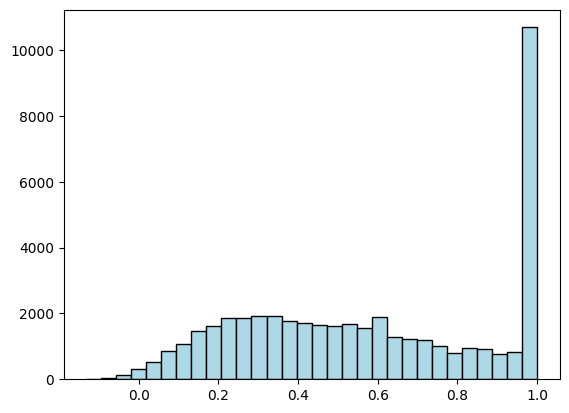

In [22]:
plt.hist(sim_scores_pos, color='lightblue', ec='black', bins=30)

(array([1.000e+00, 1.200e+01, 1.060e+02, 3.990e+02, 1.100e+03, 2.087e+03,
        3.431e+03, 4.738e+03, 5.486e+03, 5.661e+03, 5.437e+03, 4.604e+03,
        3.487e+03, 2.626e+03, 1.895e+03, 1.298e+03, 9.260e+02, 7.070e+02,
        4.610e+02, 3.270e+02, 1.980e+02, 1.080e+02, 5.800e+01, 2.000e+01,
        1.300e+01, 9.000e+00, 4.000e+00, 4.000e+00, 5.000e+00, 9.000e+00]),
 array([-0.2029227 , -0.16282527, -0.12272785, -0.08263042, -0.04253299,
        -0.00243556,  0.03766186,  0.07775929,  0.11785672,  0.15795414,
         0.19805157,  0.238149  ,  0.27824643,  0.31834385,  0.35844129,
         0.39853871,  0.43863612,  0.47873357,  0.51883101,  0.55892843,
         0.59902585,  0.63912326,  0.67922068,  0.71931815,  0.75941557,
         0.79951298,  0.8396104 ,  0.87970781,  0.91980529,  0.9599027 ,
         1.00000012]),
 <BarContainer object of 30 artists>)

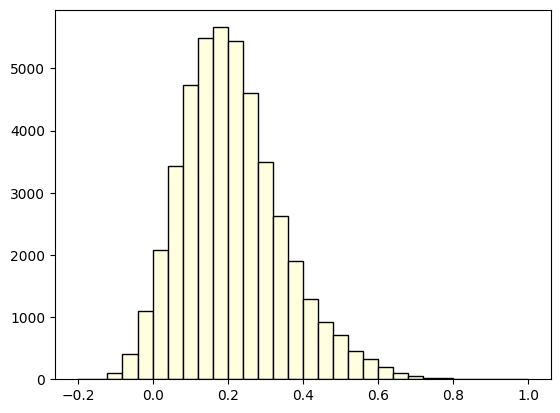

In [24]:
plt.hist(sim_scores_neg, color='lightyellow', ec='black', bins=30)

### Calculate accuracy. Given a query br, see if all of their duplicates are in top 10

In [27]:
loaded_data = np.load('netbeans_sbert_short_desc.npz')
vectors = [loaded_data[str(b)] for b in tqdm(idx_to_bug_id)]

In [25]:
Q_set = union_find.get_all_children()

In [36]:
accuracies = []

for bug_id in tqdm(Q_set):
    children = union_find.get_children(bug_id)
    assert(bug_id in children)
    children.remove(bug_id)
    for child in children:
        assert(child in idx_to_bug_id)
    
    vector = loaded_data[str(bug_id)]
    # children_vectors = [ loaded_data[str(b)] for b in children]
    
    topk_indeces, sim_scores = top_closest_values_indeces(11, np.array(vectors), np.array(vector))
    
    
    topk = [idx_to_bug_id[i] for i in topk_indeces]
    
    if bug_id in topk:
        index_to_delete = topk.index(bug_id)
        
        topk.pop(index_to_delete)
        topk_indeces.pop(index_to_delete)
        sim_scores.pop(index_to_delete)
    
    children_is_in_top_k = []
    for child in children:
        if child in topk:
            children_is_in_top_k.append(1)
        else:
            children_is_in_top_k.append(0)
            
    children_in_top_k = list(set(children).intersection(set(topk)))
    
    # print(f"{len(children_in_top_k)} out of {len(children)} children are in top k, they are {children_in_top_k}")
    accuracy = len(children_in_top_k) / len(children)
    accuracies.append(accuracy)

100%|██████████| 20543/20543 [3:39:50<00:00,  1.56it/s]  


In [39]:
print(np.mean(accuracies), np.std(accuracies))
print(np.max(accuracies), np.min(accuracies))

0.365531834941429 0.4361047363550814
1.0 0.0


(array([10380.,   149.,   165.,   218.,   164.,   245.,   255.,   347.,
           89.,    63.,   429.,    52.,   142.,    60.,     0.,  1063.,
           36.,    49.,    73.,    35.,   327.,    65.,   155.,    35.,
           99.,    87.,    26.,    17.,     0.,  5718.]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 30 artists>)

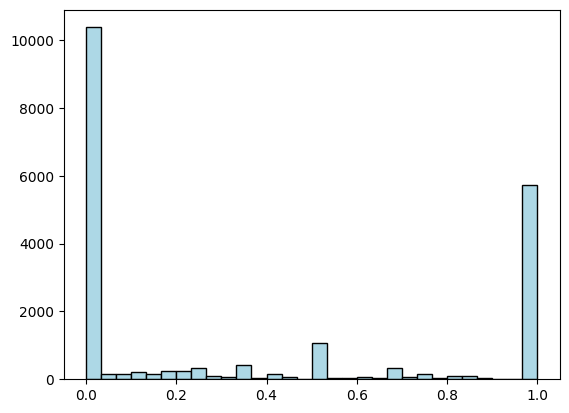

In [40]:
plt.hist(accuracies, color='lightblue', ec='black', bins=30)

Number of br with no short desc is insignificant

In [34]:
num_br_w_empty_short_desc = 0

for point in dataset:
    short_desc = point["short_desc"]
    if len(short_desc) == 0:
        num_br_w_empty_short_desc += 1

print(num_br_w_empty_short_desc)

4


## when desc with stacktrace is used

In [ ]:
def get_similarity_of_pair_with_desc(dataset, idx_to_bug_id, pair):
    index0 = idx_to_bug_id.index(pair[0])
    index1 = idx_to_bug_id.index(pair[1])
    sent0 = dataset[index0]["description"]
    sent1 = dataset[index1]["description"]
    sent_embedding0 = model.encode(sent0,convert_to_tensor=True)
    sent_embedding1 = model.encode(sent1,convert_to_tensor=True)
    return util.pytorch_cos_sim(sent_embedding0, sent_embedding1).numpy()[0, 0]

In [ ]:
sim_scores_pos = np.array([get_similarity_of_pair_with_desc(dataset, idx_to_bug_id, pair) for pair in positive_set])
sim_scores_neg = np.array([get_similarity_of_pair_with_desc(dataset, idx_to_bug_id, pair) for pair in negative_set])

In [ ]:
print(sim_scores_pos.mean(), sim_scores_pos.std())
print(sim_scores_neg.mean(), sim_scores_neg.std())

In [ ]:
plt.hist(sim_scores_pos, color='lightblue', ec='black', bins=30)

In [ ]:
plt.hist(sim_scores_neg, color='lightblue', ec='black', bins=30)

sim_scores_pos = np.array([get_similarity_of_pair_with_short_desc(dataset, idx_to_bug_id, pair) for pair in positive_set])
sim_scores_neg = np.array([get_similarity_of_pair_with_short_desc(dataset, idx_to_bug_id, pair) for pair in negative_set])